In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 전처리 - 정규화 - train set 클러스터링

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
import platform
import matplotlib as mpl
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
#from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

In [51]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT 사각김밥_(머신러닝 스터디)/data6.csv', index_col=0)
df = df.loc[:, ~df.columns.isin(['창업이전', '창업이후'])]
df['기업형태'] = np.where(df['기업형태'] == '법인', 1, 0)
df.rename(columns={'기업형태':'법인기업'}, inplace=True)
df['창업자 학력'].value_counts()
df['창업자학력'] = df['창업자 학력'].map({'중졸이하':1, '고졸':2, '전문대졸':3, '대졸':4, '석사':5, '박사':5})

df = df.drop('창업자 학력', axis=1)
df['창업자학력'].value_counts()
df['사업장 입지'].value_counts()
df['상업지역'] = df['사업장 입지'].map({'일반상업':1, '일반주택':0, '기타':0, '산업단지':0, '대학':0})

df = df.drop('사업장 입지', axis=1)
df['상업지역'].value_counts()
df

법인기업  창업횟수  창업인원      매출액      영업이익  금융비용(이자비용)     당기순이익  \
0         1     1     1   265000  15100.00      900.00   4750.00   
2         1     2     2   677000  63045.00    29020.00  46147.00   
3         1     1     1  3936000 264000.00    34300.00 139300.00   
4         1     1     1  5668000 170900.00    18300.00 144850.00   
5         1     1     1    85000   2100.00     1200.00   2050.00   
...     ...   ...   ...      ...       ...         ...       ...   
31974     1     1     3   524000 152900.00        0.00 110300.00   
31975     1     1     1   782300  31200.00        0.00  22500.00   
31976     0     1     1   526000 191900.00        0.00 138500.00   
31977     0     1     1   620000 201500.00      400.00 145400.00   
31978     0     1     6   803300  93600.00        0.00  22500.00   

       B2C 소비자 매출(%)  B2G 정부 매출(%)  연간 자금 사용금액  전체 인력  자산대비 자금사용비율  창업자학력  \
0                100             0   101850.00      1        55.22      1   
2                100             0   136948.00      4       970.21      1   
3                  0             0   288880.00     17        32.13      1   
4                100             0   572130.00     26        15.77      1   
5                100             0   110900.00      2      1896.98      1   
...              ...           ...         ...    ...          ...    ...   
31974              0             0   882000.00      6        15.87      4   
31975              0             0   380000.00      9        23.95      4   
31976            100             0    16000.00      7       481.25      4   
31977             70             0  1162800.00     15        12.04      4   
31978            100             0    80000.00      2       778.75      2   

       상업지역  
0         0  
2         1  
3         0  
4         0  
5         0  
...     ...  
31974     0  
31975     1  
31976     0  
31977     0  
31978     0  

[22540 rows x 14 columns]

In [4]:
df.columns

Index(['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용(이자비용)', '당기순이익',
       'B2C 소비자 매출(%)', 'B2G 정부 매출(%)', '연간 자금 사용금액', '전체 인력', '자산대비 자금사용비율',
       '창업자학력', '상업지역'],
      dtype='object')

In [52]:
def replace_space_with_underscore(df):
    df.columns = df.columns.str.replace(' ', '')
    return df

# 데이터프레임의 열 이름에서 공백을 언더스코어로 대체
df = replace_space_with_underscore(df)
df.rename(columns={'B2G정부매출(%)': 'B2G정부매출'}, inplace=True)
df.rename(columns={'B2C소비자매출(%)': 'B2C소비자매출'}, inplace=True)
df.rename(columns={'금융비용(이자비용)': '금융비용'}, inplace=True)


In [53]:
# 연속형 변수 정규화
scale_col = ['매출액', '영업이익', '금융비용', '연간자금사용금액', '자산대비자금사용비율']
scaler = StandardScaler()
df[scale_col] = scaler.fit_transform(df[scale_col])

In [54]:
# 클러스터링
from sklearn.cluster import AgglomerativeClustering
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df['당기순이익_scale'] = scaler.fit_transform(train_df[['당기순이익']])
agg = AgglomerativeClustering(n_clusters=3)
pre_col=['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용', '당기순이익_scale', 'B2C소비자매출',
       'B2G정부매출', '연간자금사용금액', '전체인력', '자산대비자금사용비율', '창업자학력', '상업지역']
train_df['AgglomerativeClustering']=agg.fit_predict(train_df[pre_col])
train_df.drop(axis=1,columns='당기순이익_scale',inplace= True)

In [55]:
train_df.head()

법인기업  창업횟수  창업인원   매출액  영업이익  금융비용    당기순이익  B2C소비자매출  B2G정부매출  \
25043     1     1     1 -0.31 -0.06 -0.09 19200.00       100        0   
27250     1     1     2 -0.31 -0.08 -0.09  3500.00         0        0   
15623     0     2     1 -0.01 -0.04 -0.09 43700.00       100        0   
26218     1     2     1 -0.28  0.00 -0.09 28100.00         0        0   
16795     0     1     2 -0.29 -0.54  0.03  2880.00       100        0   

       연간자금사용금액  전체인력  자산대비자금사용비율  창업자학력  상업지역  AgglomerativeClustering  
25043     -0.13     0       -0.08      5     0                        1  
27250     -0.21     0       -0.06      2     0                        0  
15623      0.03    15       -0.08      4     1                        1  
26218     -0.09     1       -0.08      5     0                        0  
16795      0.01     0       -0.07      4     0                        1

### original df 에 군집column 추가

In [56]:
df_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DAT 사각김밥_(머신러닝 스터디)/data6.csv', index_col=0)
df_original = df_original.loc[:, ~df_original.columns.isin(['창업이전', '창업이후'])]
df_original['기업형태'] = np.where(df_original['기업형태'] == '법인', 1, 0)
df_original.rename(columns={'기업형태':'법인기업'}, inplace=True)
df_original['창업자 학력'].value_counts()
df_original['창업자학력'] = df_original['창업자 학력'].map({'중졸이하':1, '고졸':2, '전문대졸':3, '대졸':4, '석사':5, '박사':5})

df_original = df_original.drop('창업자 학력', axis=1)
df_original['창업자학력'].value_counts()
df_original['사업장 입지'].value_counts()
df_original['상업지역'] = df_original['사업장 입지'].map({'일반상업':1, '일반주택':0, '기타':0, '산업단지':0, '대학':0})

df_original = df_original.drop('사업장 입지', axis=1)
df_original['상업지역'].value_counts()
df_original

법인기업  창업횟수  창업인원      매출액      영업이익  금융비용(이자비용)     당기순이익  \
0         1     1     1   265000  15100.00      900.00   4750.00   
2         1     2     2   677000  63045.00    29020.00  46147.00   
3         1     1     1  3936000 264000.00    34300.00 139300.00   
4         1     1     1  5668000 170900.00    18300.00 144850.00   
5         1     1     1    85000   2100.00     1200.00   2050.00   
...     ...   ...   ...      ...       ...         ...       ...   
31974     1     1     3   524000 152900.00        0.00 110300.00   
31975     1     1     1   782300  31200.00        0.00  22500.00   
31976     0     1     1   526000 191900.00        0.00 138500.00   
31977     0     1     1   620000 201500.00      400.00 145400.00   
31978     0     1     6   803300  93600.00        0.00  22500.00   

       B2C 소비자 매출(%)  B2G 정부 매출(%)  연간 자금 사용금액  전체 인력  자산대비 자금사용비율  창업자학력  \
0                100             0   101850.00      1        55.22      1   
2                100             0   136948.00      4       970.21      1   
3                  0             0   288880.00     17        32.13      1   
4                100             0   572130.00     26        15.77      1   
5                100             0   110900.00      2      1896.98      1   
...              ...           ...         ...    ...          ...    ...   
31974              0             0   882000.00      6        15.87      4   
31975              0             0   380000.00      9        23.95      4   
31976            100             0    16000.00      7       481.25      4   
31977             70             0  1162800.00     15        12.04      4   
31978            100             0    80000.00      2       778.75      2   

       상업지역  
0         0  
2         1  
3         0  
4         0  
5         0  
...     ...  
31974     0  
31975     1  
31976     0  
31977     0  
31978     0  

[22540 rows x 14 columns]

In [57]:
def replace_space_with_underscore(df):
    df.columns = df.columns.str.replace(' ', '')
    return df

# 데이터프레임의 열 이름에서 공백을 언더스코어로 대체
df_original = replace_space_with_underscore(df_original)
df_original.rename(columns={'B2G정부매출(%)': 'B2G정부매출'}, inplace=True)
df_original.rename(columns={'B2C소비자매출(%)': 'B2C소비자매출'}, inplace=True)
df_original.rename(columns={'금융비용(이자비용)': '금융비용'}, inplace=True)


In [58]:
train_df_original, test_df_original = train_test_split(df_original, test_size=0.2, random_state=42)
train_df_original

법인기업  창업횟수  창업인원      매출액       영업이익     금융비용    당기순이익  B2C소비자매출  \
25043     1     1     1    27700   19200.00     0.00 19200.00       100   
27250     1     1     2    14700    3500.00   100.00  3500.00         0   
15623     0     2     1  1239000   44600.00     0.00 43700.00       100   
26218     1     2     1   128000   81900.00     0.00 28100.00         0   
16795     0     1     2   107000 -433000.00 41000.00  2880.00       100   
...     ...   ...   ...      ...        ...      ...      ...       ...   
16651     1     1     1  1271000   53664.00 14893.00 28867.00       100   
30653     1     1     1    10000       0.00     0.00     0.00       100   
7272      0     1     1   155000    2600.00  1600.00  1250.00       100   
1154      1     2     1  2089000   74600.00  8500.00 22750.00        50   
22261     0     2     2    61300   11034.00     0.00  5402.00       100   

       B2G정부매출   연간자금사용금액  전체인력  자산대비자금사용비율  창업자학력  상업지역  
25043        0  360000.00     0       15.56      5     0  
27250        0   12600.00     0     1944.44      2     0  
15623        0 1023000.00    15       10.07      4     1  
26218        0  525000.00     1       21.33      5     0  
16795        0  970000.00     0      997.73      4     0  
...        ...        ...   ...         ...    ...   ...  
16651        0  369300.00     4      127.46      2     1  
30653        0   45000.00     0      155.56      5     1  
7272         0  192220.00     5        9.26      2     1  
1154         0  225990.00     8      188.09      2     1  
22261        0  248000.00     0       85.16      2     0  

[18032 rows x 14 columns]

In [59]:
train_df_original = pd.concat([train_df_original, train_df['AgglomerativeClustering']], axis=1)
train_df_original

법인기업  창업횟수  창업인원      매출액       영업이익     금융비용    당기순이익  B2C소비자매출  \
25043     1     1     1    27700   19200.00     0.00 19200.00       100   
27250     1     1     2    14700    3500.00   100.00  3500.00         0   
15623     0     2     1  1239000   44600.00     0.00 43700.00       100   
26218     1     2     1   128000   81900.00     0.00 28100.00         0   
16795     0     1     2   107000 -433000.00 41000.00  2880.00       100   
...     ...   ...   ...      ...        ...      ...      ...       ...   
16651     1     1     1  1271000   53664.00 14893.00 28867.00       100   
30653     1     1     1    10000       0.00     0.00     0.00       100   
7272      0     1     1   155000    2600.00  1600.00  1250.00       100   
1154      1     2     1  2089000   74600.00  8500.00 22750.00        50   
22261     0     2     2    61300   11034.00     0.00  5402.00       100   

       B2G정부매출   연간자금사용금액  전체인력  자산대비자금사용비율  창업자학력  상업지역  \
25043        0  360000.00     0       15.56      5     0   
27250        0   12600.00     0     1944.44      2     0   
15623        0 1023000.00    15       10.07      4     1   
26218        0  525000.00     1       21.33      5     0   
16795        0  970000.00     0      997.73      4     0   
...        ...        ...   ...         ...    ...   ...   
16651        0  369300.00     4      127.46      2     1   
30653        0   45000.00     0      155.56      5     1   
7272         0  192220.00     5        9.26      2     1   
1154         0  225990.00     8      188.09      2     1   
22261        0  248000.00     0       85.16      2     0   

       AgglomerativeClustering  
25043                        1  
27250                        0  
15623                        1  
26218                        0  
16795                        1  
...                        ...  
16651                        1  
30653                        1  
7272                         1  
1154                         0  
22261                        1  

[18032 rows x 15 columns]

In [60]:
# 군집별 데이터 프레임 분할
df_군집0=train_df_original[train_df_original['AgglomerativeClustering']==0]
df_군집1=train_df_original[train_df_original['AgglomerativeClustering']==1]
df_군집2=train_df_original[train_df_original['AgglomerativeClustering']==2]

In [61]:
df_군집0

법인기업  창업횟수  창업인원      매출액       영업이익     금융비용     당기순이익  B2C소비자매출  \
27250     1     1     2    14700    3500.00   100.00   3500.00         0   
26218     1     2     1   128000   81900.00     0.00  28100.00         0   
11502     0     1     2   467000    4500.00   100.00   4300.00         0   
6977      0     1     1  4974000 -101475.00     0.00 -86794.00         0   
18697     0     1     1    98000    4900.00     0.00   1960.00         0   
...     ...   ...   ...      ...        ...      ...       ...       ...   
7157      0     1     1    33000  -57296.00 17832.00 -66931.00        50   
1034      1     1     1   367000   13700.00  1900.00   5050.00         0   
22595     0     1     1   240000    7236.00     0.00  10506.00         0   
23789     1     1     1   200300    4500.00     0.00   2448.00        30   
1154      1     2     1  2089000   74600.00  8500.00  22750.00        50   

       B2G정부매출  연간자금사용금액  전체인력  자산대비자금사용비율  창업자학력  상업지역  \
27250        0  12600.00     0     1944.44      2     0   
26218        0 525000.00     1       21.33      5     0   
11502        0 693000.00     2       23.81      2     0   
6977         0 583170.00   137      132.74      5     1   
18697        0 240000.00     0        3.33      4     0   
...        ...       ...   ...         ...    ...   ...   
7157         0  85023.00     6      503.80      5     1   
1034         0  17740.00     2       25.25      2     1   
22595        0  45000.00     2      279.44      2     0   
23789        0  17430.00     1       19.51      4     1   
1154         0 225990.00     8      188.09      2     1   

       AgglomerativeClustering  
27250                        0  
26218                        0  
11502                        0  
6977                         0  
18697                        0  
...                        ...  
7157                         0  
1034                         0  
22595                        0  
23789                        0  
1154                         0  

[6874 rows x 15 columns]

In [14]:
train_df_original.columns

Index(['법인기업', '창업횟수', '창업인원', '매출액', '영업이익', '금융비용', '당기순이익', 'B2C소비자매출',
       'B2G정부매출', '연간자금사용금액', '전체인력', '자산대비자금사용비율', '창업자학력', '상업지역',
       'AgglomerativeClustering'],
      dtype='object')

In [22]:
numerical_cols =['매출액', '영업이익', '금융비용', '당기순이익', 'B2C소비자매출',
       'B2G정부매출', '연간자금사용금액', '전체인력', '자산대비자금사용비율']
numerical_cols

['매출액',
 '영업이익',
 '금융비용',
 '당기순이익',
 'B2C소비자매출',
 'B2G정부매출',
 '연간자금사용금액',
 '전체인력',
 '자산대비자금사용비율']

In [46]:
categorial_cols = ['법인기업', '창업횟수', '창업인원', '창업자학력', '상업지역', 'AgglomerativeClustering']
categorial_cols

['법인기업', '창업횟수', '창업인원', '창업자학력', '상업지역', 'AgglomerativeClustering']

### 연속형 변수

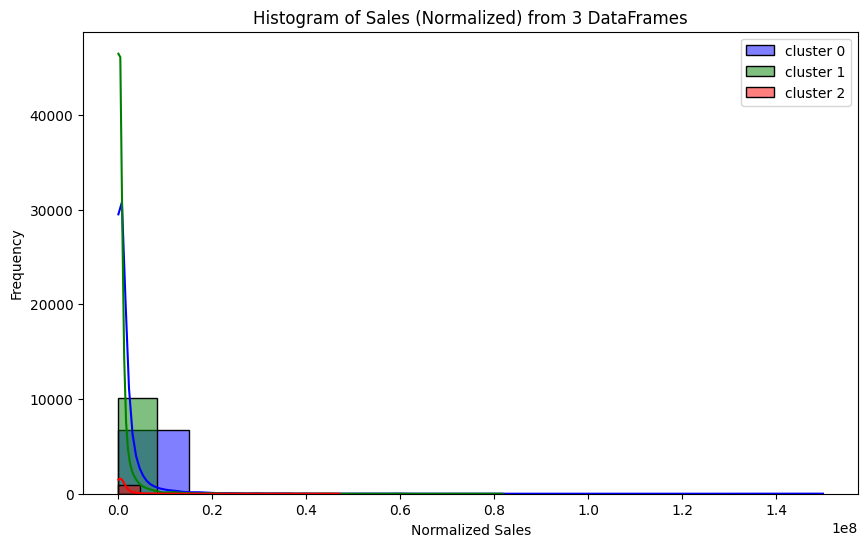

In [18]:
plt.figure(figsize=(10, 6))

sns.histplot(df_군집0['매출액'], bins=10, kde=True, color='blue', label='cluster 0', alpha=0.5)
sns.histplot(df_군집1['매출액'], bins=10, kde=True, color='green', label='cluster 1', alpha=0.5)
sns.histplot(df_군집2['매출액'], bins=10, kde=True, color='red', label='cluster 2', alpha=0.5)

plt.title('Histogram of Sales (Normalized) from 3 DataFrames')
plt.xlabel('Normalized Sales')
plt.ylabel('Frequency')
plt.legend()
plt.show()


<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
<ipython-input-31-1fc368b4de08>:10: UserWarning: Glyph 

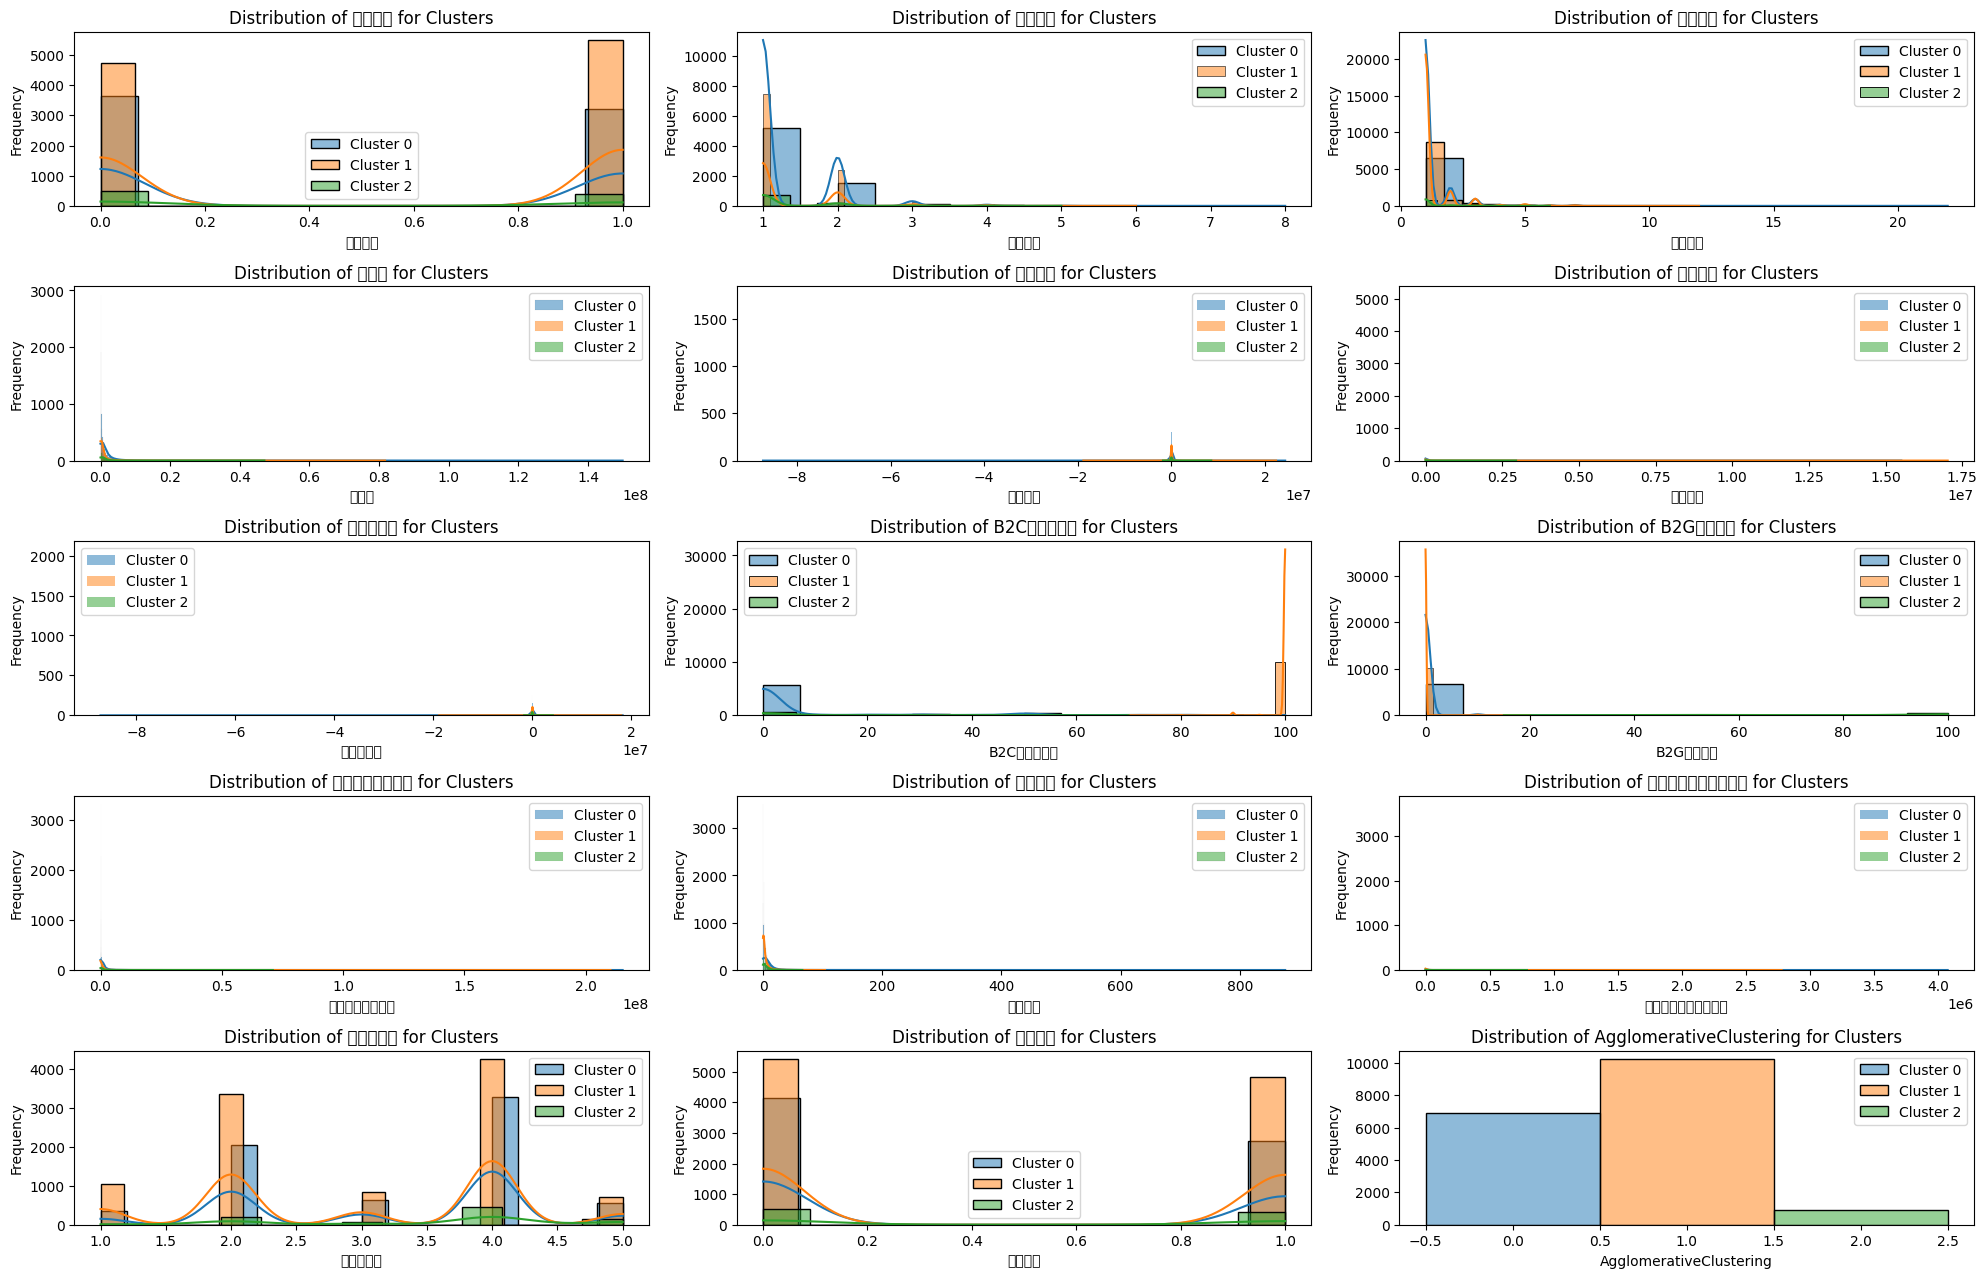

In [31]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(train_df_original.columns):
    plt.subplot(6, 3, i+1)
    for cluster_id in range(3):
        sns.histplot(train_df_original[train_df_original['AgglomerativeClustering'] == cluster_id][column], kde=True, label=f'Cluster {cluster_id}', alpha=0.5)
    plt.title(f'Distribution of {column} for Clusters')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

In [36]:
from matplotlib.ticker import ScalarFormatter

In [45]:
# 군집별 당기순이익 비교

desc_군집0 = df_군집0['당기순이익'].describe()
desc_군집1 = df_군집1['당기순이익'].describe()
desc_군집2 = df_군집2['당기순이익'].describe()

summary_df = pd.concat([desc_군집0, desc_군집1, desc_군집2], axis=1)
summary_df.columns = ['군집 0', '군집 1', '군집 2']

pd.set_option('display.float_format', '{:.2f}'.format)
summary_df

군집 0         군집 1        군집 2
count      6874.00     10247.00      911.00
mean      43900.47     38457.28    50376.43
std     1275469.39    498085.63   272852.08
min   -87243682.00 -18786426.00 -1623017.00
25%        2212.50       650.00     1000.00
50%       18744.00      6000.00    10900.00
75%       71698.00     30000.00    50985.00
max    18285300.00  17978968.00  4170558.00

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

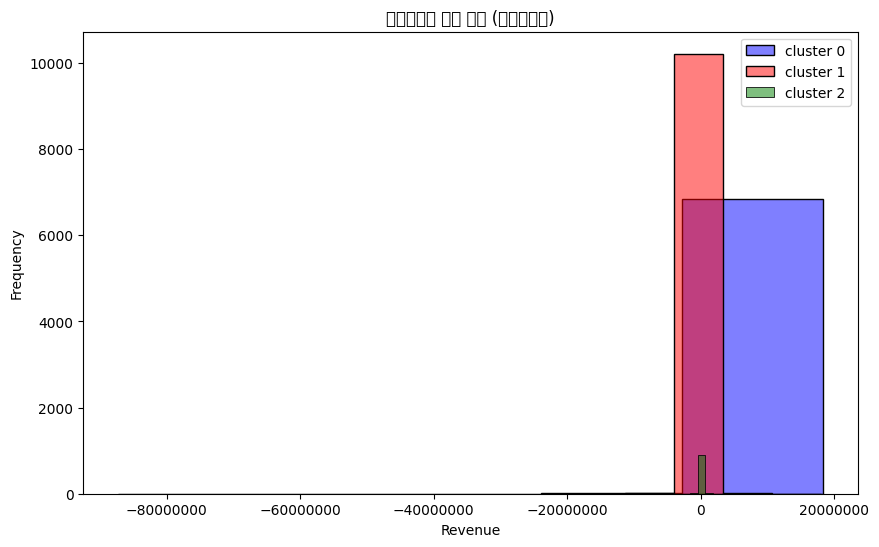

In [35]:
# 당기순이익 분포 비교
plt.figure(figsize=(10, 6))

sns.histplot(df_군집0['당기순이익'], kde=False, color='blue', label='cluster 0', bins=5, alpha=0.5)
sns.histplot(df_군집1['당기순이익'], kde=False, color='red', label='cluster 1', bins=5, alpha=0.5)
sns.histplot(df_군집2['당기순이익'], kde=False, color='green', label='cluster 2', bins=5, alpha=0.5)
plt.legend()
plt.title('당기순이익 분포 비교 (히스토그램)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='x')
plt.show()

<ipython-input-36-ed19d1ffeefb>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_군집0['당기순이익'], color='blue', label='df0', shade=True)
<ipython-input-36-ed19d1ffeefb>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_군집1['당기순이익'], color='red', label='df1', shade=True)
<ipython-input-36-ed19d1ffeefb>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_군집2['당기순이익'], color='green', label='df2', shade=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10

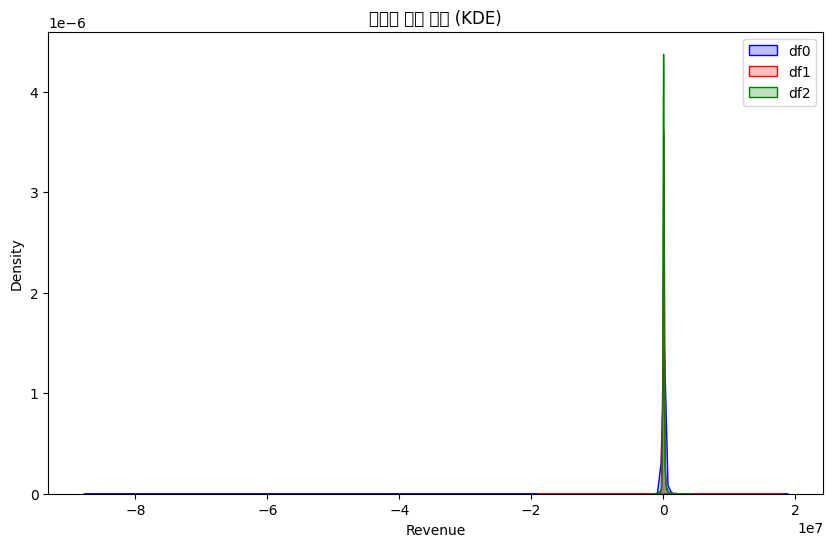

In [36]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_군집0['당기순이익'], color='blue', label='df0', shade=True)
sns.kdeplot(df_군집1['당기순이익'], color='red', label='df1', shade=True)
sns.kdeplot(df_군집2['당기순이익'], color='green', label='df2', shade=True)
plt.legend()
plt.title('매출액 분포 비교 (KDE)')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.show()

<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
<ipython-input-34-c24a85248859>:14: UserWarning: Glyph 51

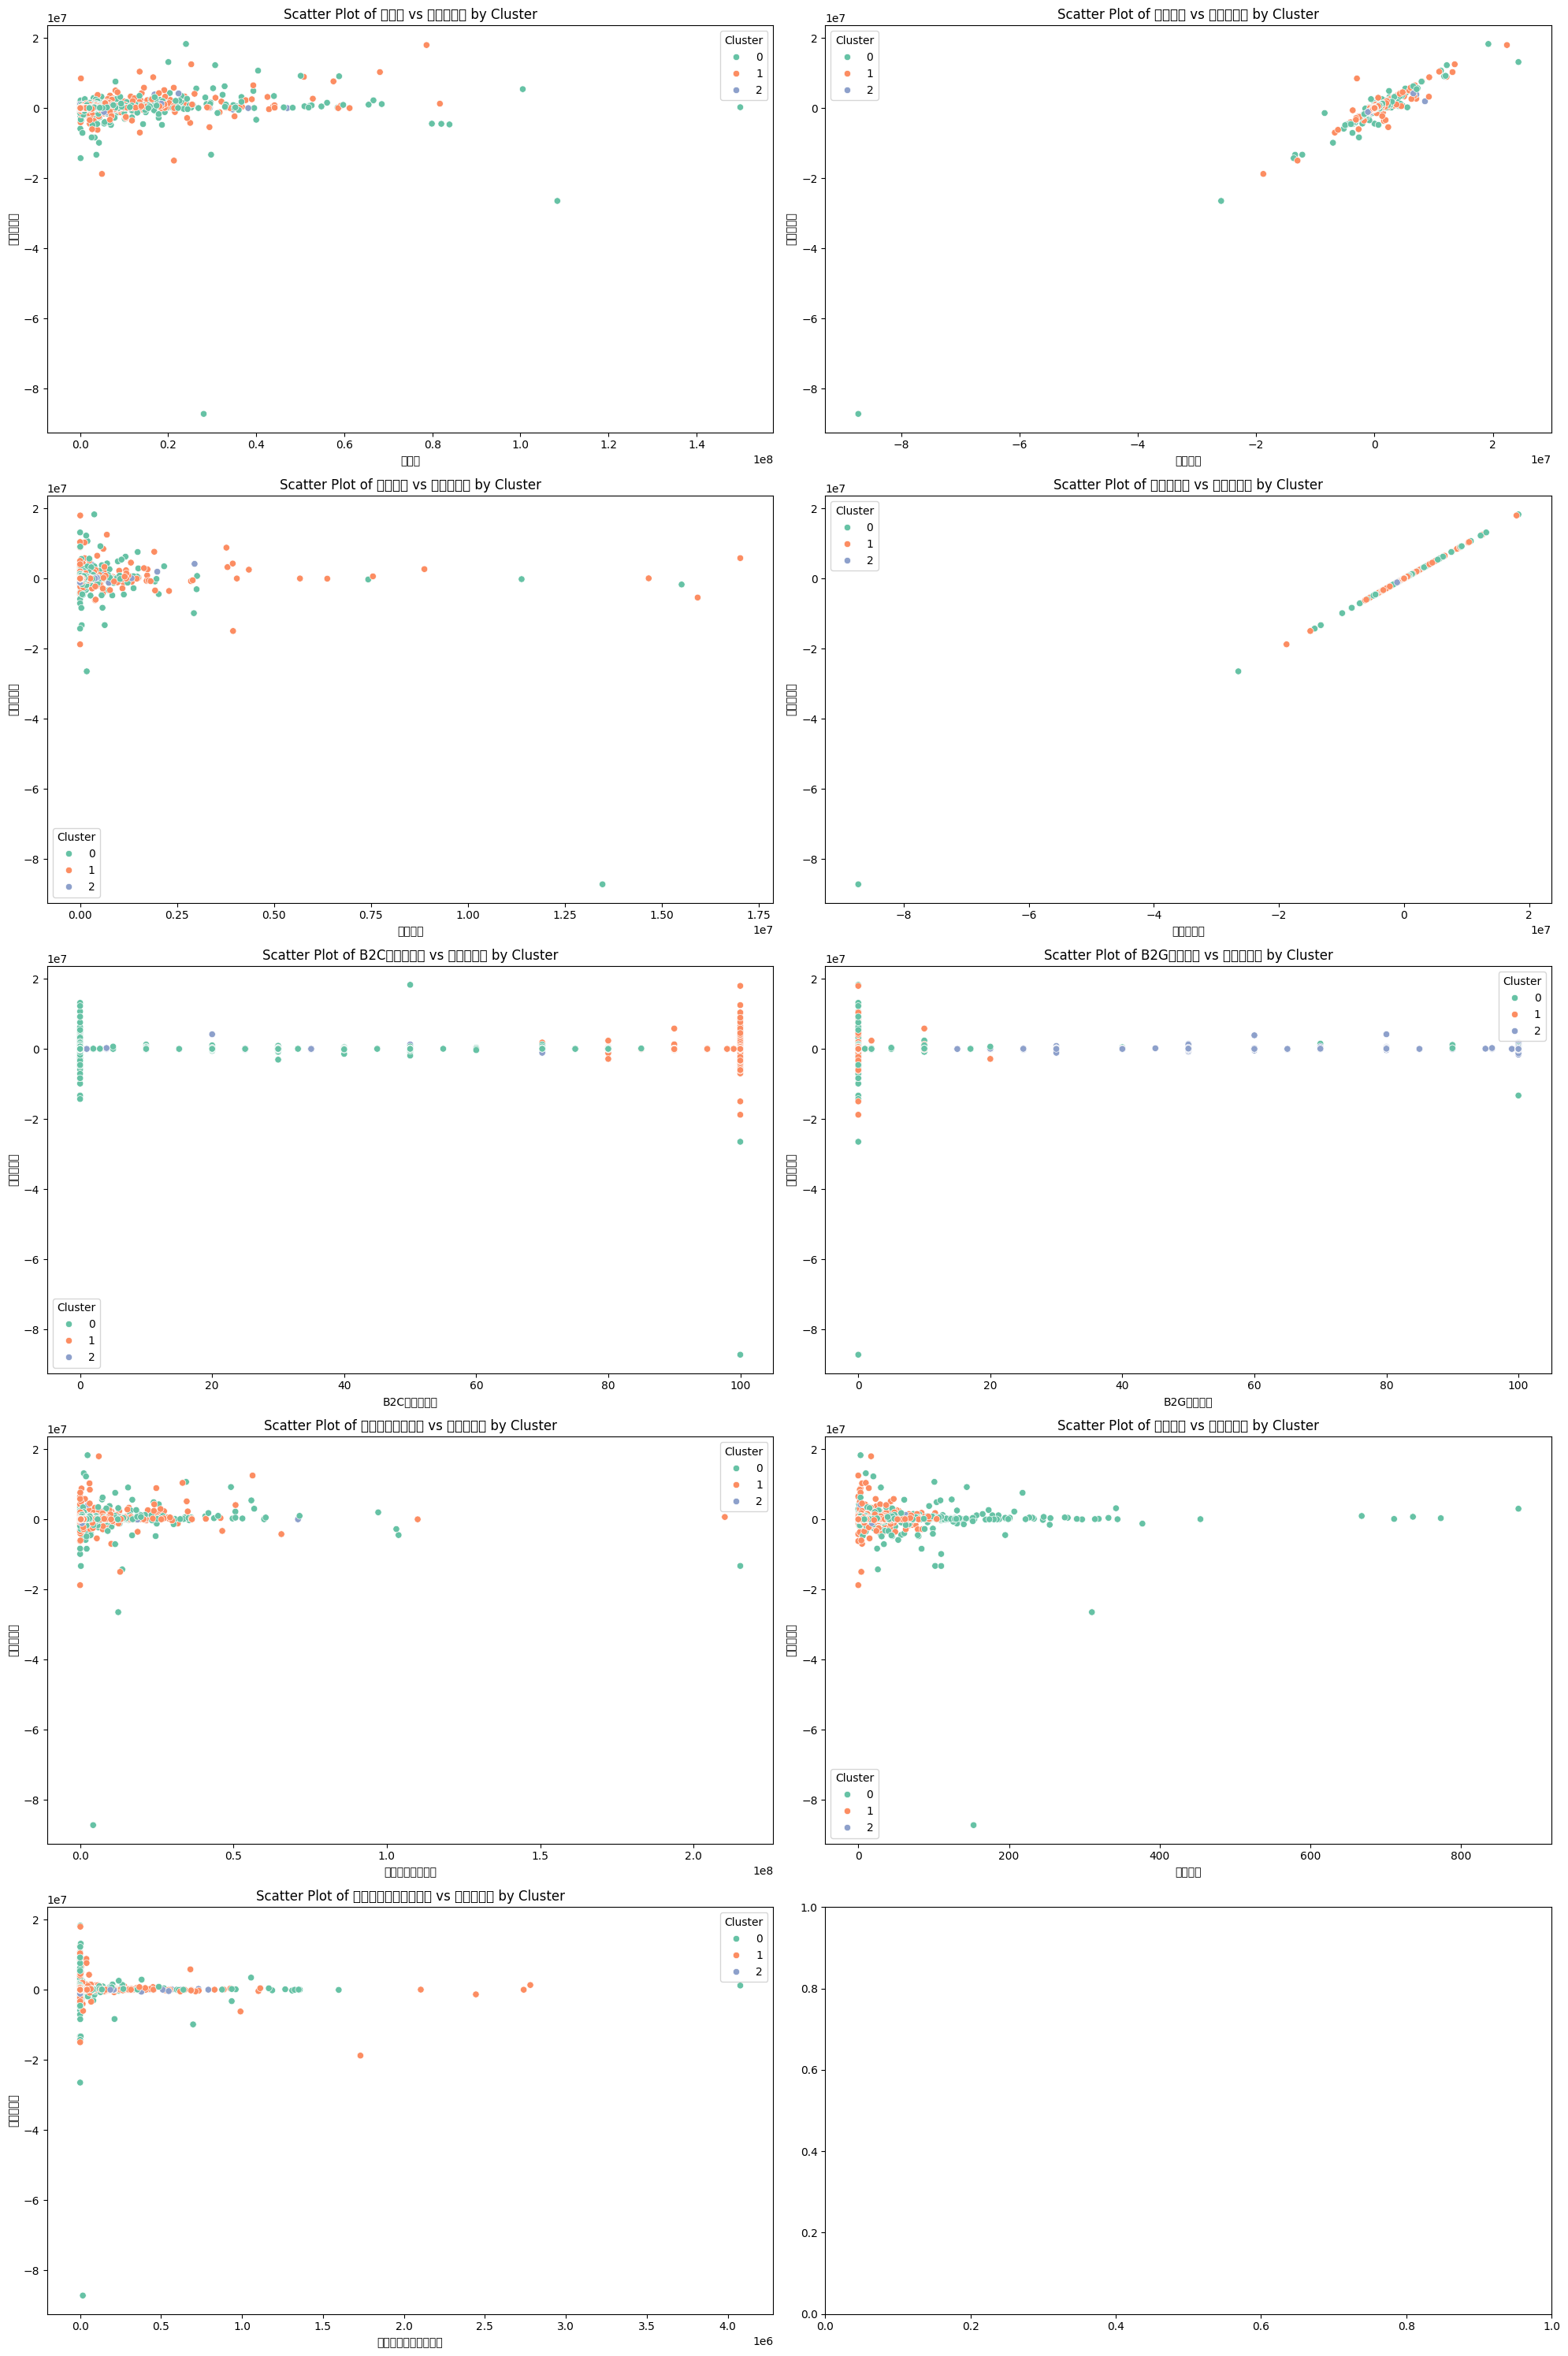

In [34]:
# 서브플롯 생성
fig, axes = plt.subplots(5, 2, figsize=(20, 30))

for i, col in enumerate(numerical_cols):
    row = i // 2
    col_pos = i % 2
    sns.scatterplot(data=train_df_original, x=col, y='당기순이익', hue='AgglomerativeClustering', palette='Set2', ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Scatter Plot of {col} vs 당기순이익 by Cluster')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('당기순이익')
    axes[row, col_pos].legend(title='Cluster')

# 레이아웃 조정
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seabor

[Text(0.5, 1.0, 'Heatmap of numerical features')]

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*ar

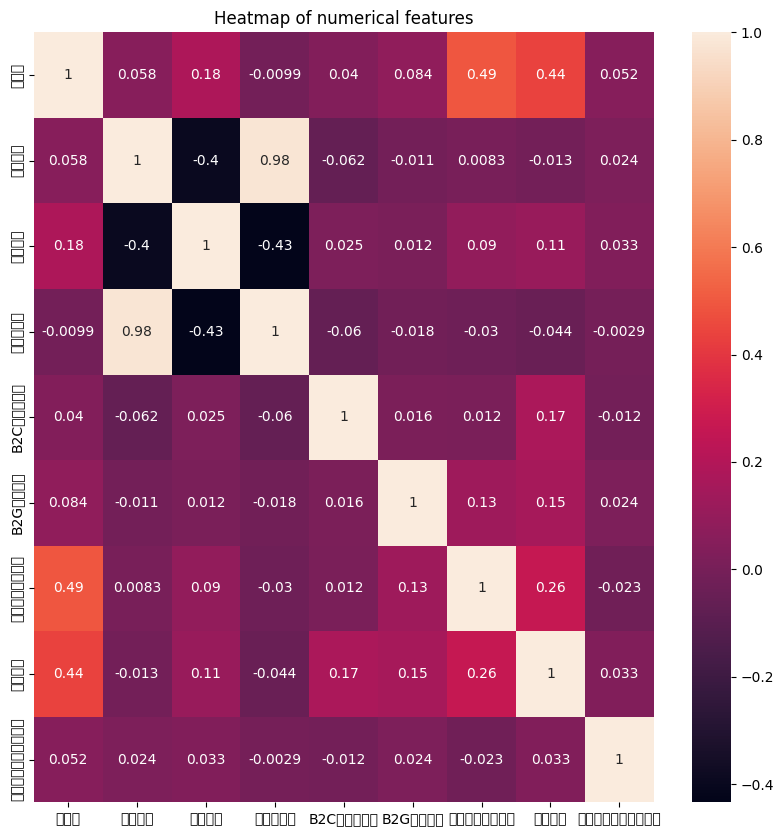

In [37]:
# 히트맵
corrMat = df_군집0[numerical_cols].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of numerical features')

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seabor

[Text(0.5, 1.0, 'Heatmap of numerical features')]

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*ar

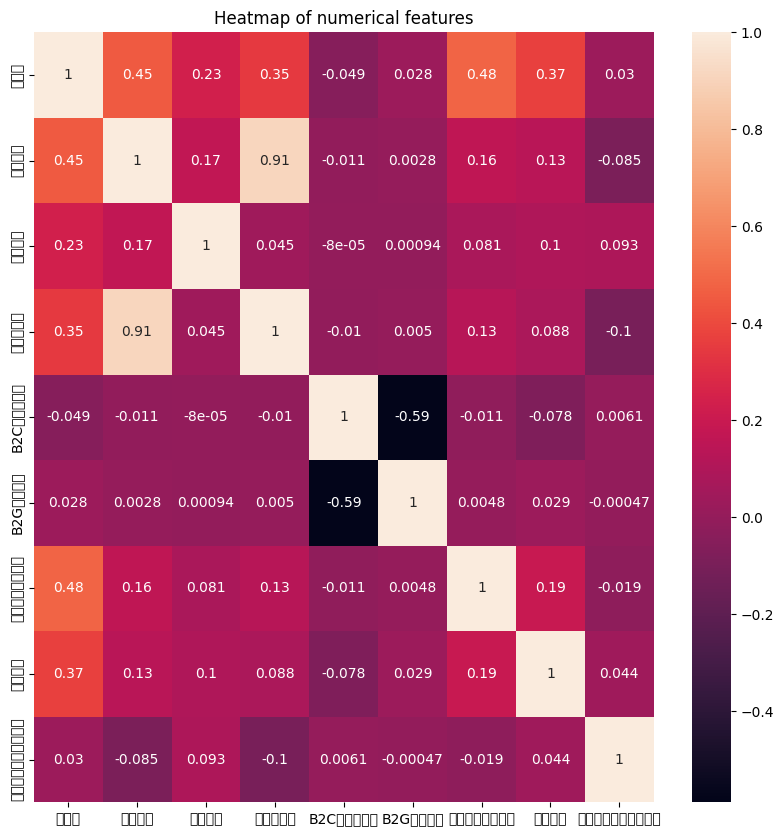

In [38]:
# 히트맵
corrMat = df_군집1[numerical_cols].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of numerical features')

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seabor

[Text(0.5, 1.0, 'Heatmap of numerical features')]

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*ar

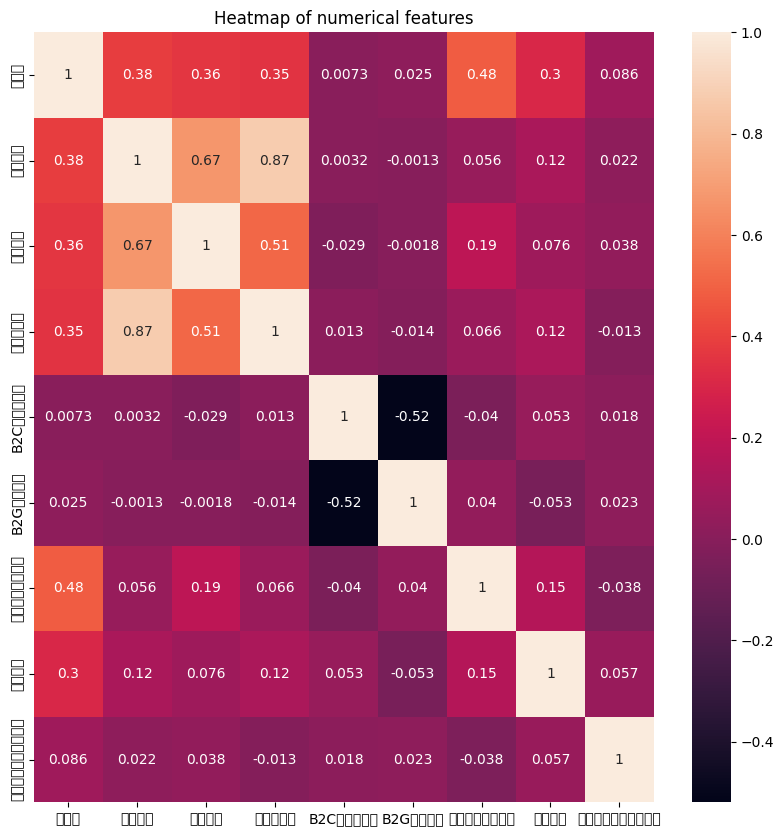

In [39]:
# 히트맵
corrMat = df_군집2[numerical_cols].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True)
ax.set(title='Heatmap of numerical features')

### 범주형 변수

In [83]:
print(categorial_cols)

['법인기업', '창업횟수', '창업인원', '창업자학력', '상업지역', 'AgglomerativeClustering']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

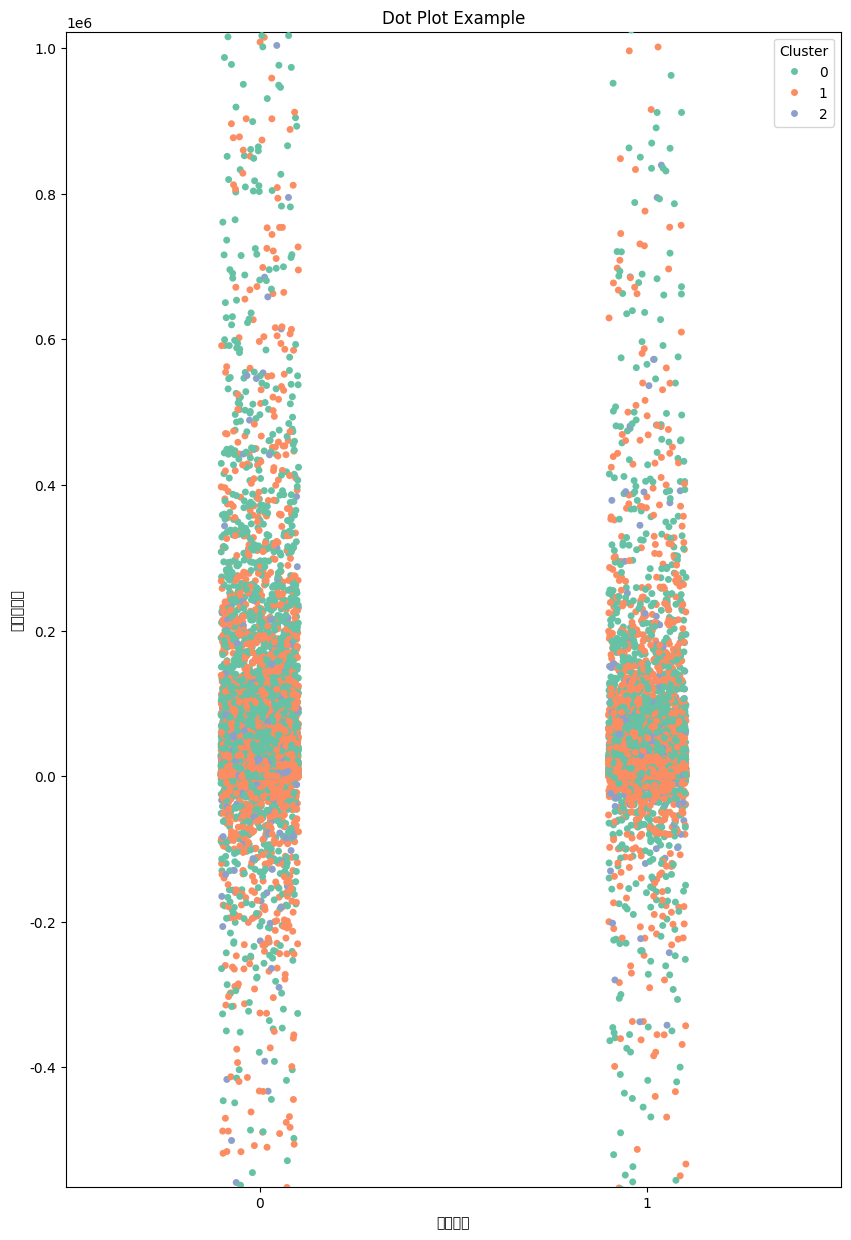

In [74]:
# 도트 플롯
plt.figure(figsize=(10, 15))
sns.stripplot(x='법인기업', y='당기순이익', hue='AgglomerativeClustering', data=train_df_original, jitter=True, palette='Set2')
plt.title('Dot Plot Example')
plt.xlabel('법인기업')
plt.ylabel('당기순이익')
plt.legend(title='Cluster')
plt.ylim(train_df_original['당기순이익'].quantile(0.01), train_df_original['당기순이익'].quantile(0.99))  # y축 범위 설정
plt.show()


<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
<ipython-input-73-7ef582ffdd00>:14: UserWarning: Glyph 51

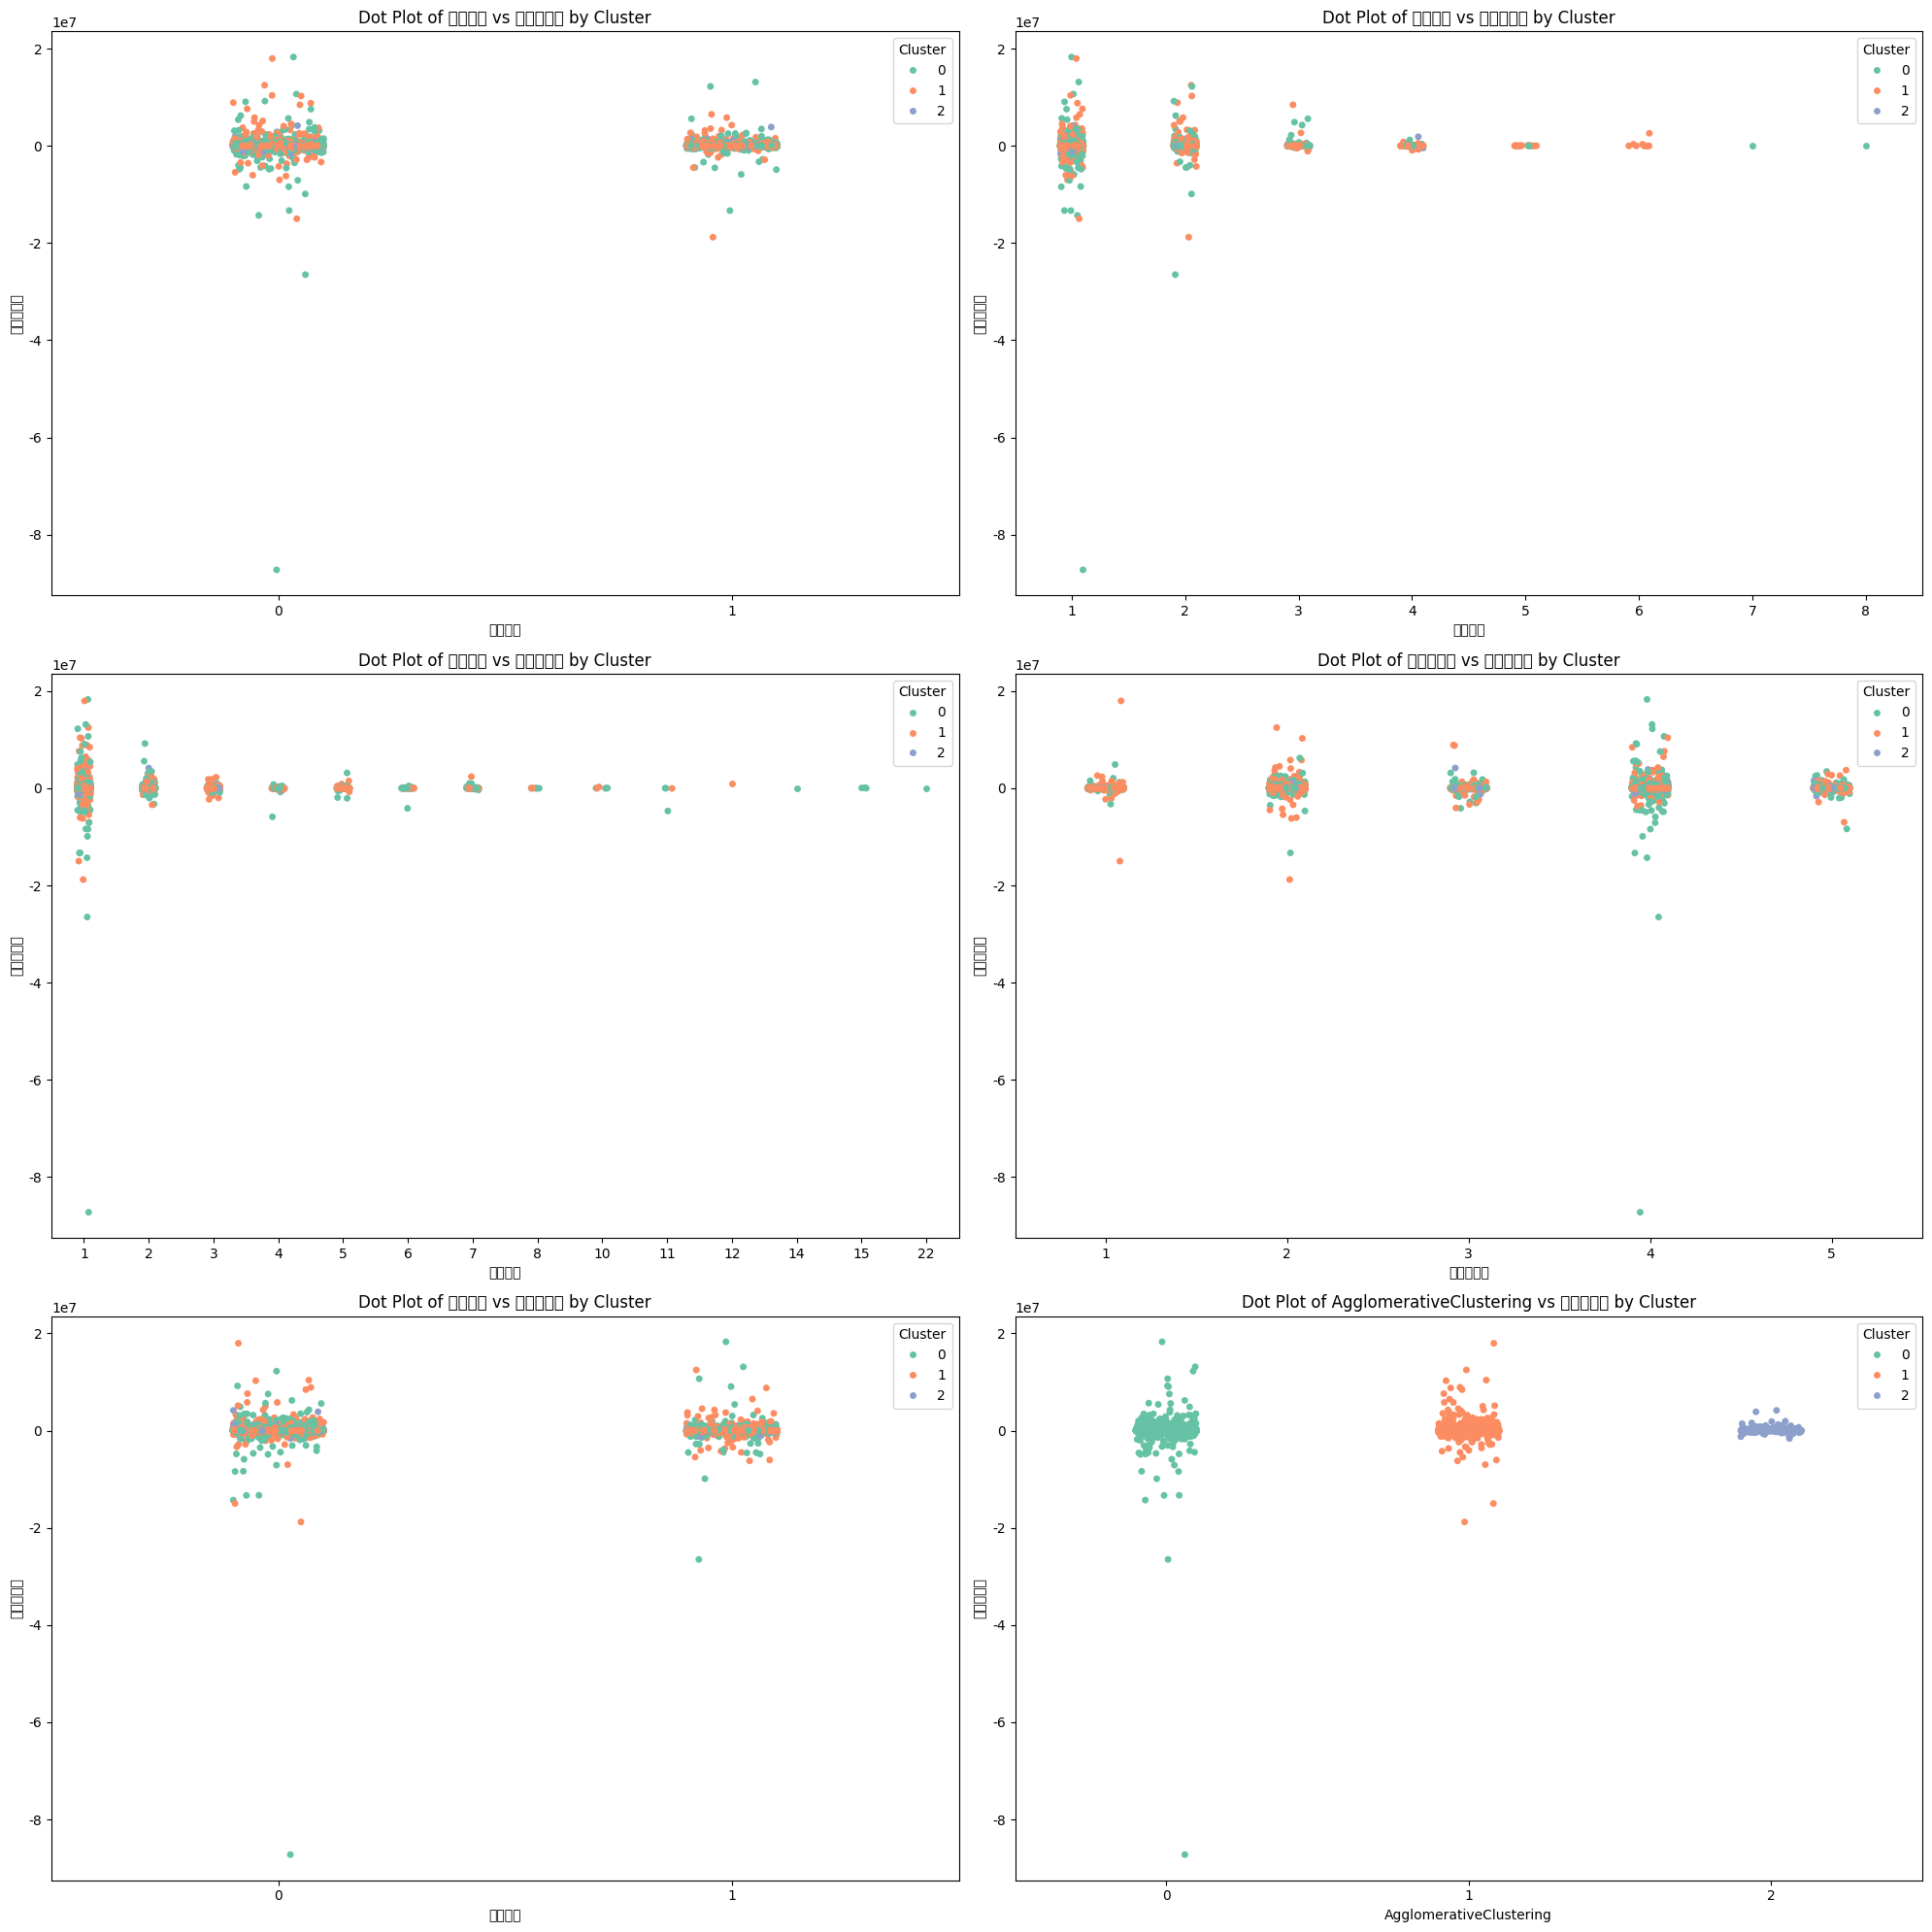

In [73]:
# 군집별 범주형 변수 분포 비교
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for i, col in enumerate(categorial_cols):
    row = i // 2
    col_pos = i % 2
    sns.stripplot(data=train_df_original, x=col, y='당기순이익', hue='AgglomerativeClustering', jitter=True, palette='Set2', ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Dot Plot of {col} vs 당기순이익 by Cluster')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].set_ylabel('당기순이익')
    axes[row, col_pos].legend(title='Cluster')

# 레이아웃 조정
plt.tight_layout()
plt.show()

<ipython-input-85-c1c5ec02bfaf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['법인기업'].value_counts().index, y=df['법인기업'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-85-c1c5ec02bfaf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['법인기업'].value_counts().index, y=df['법인기업'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-85-c1c5ec02bfaf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['법인기업'].value_counts().index, y=df['법인기업'].value_counts(), palette='Set2', ax=axes[i])
<ipython-inpu

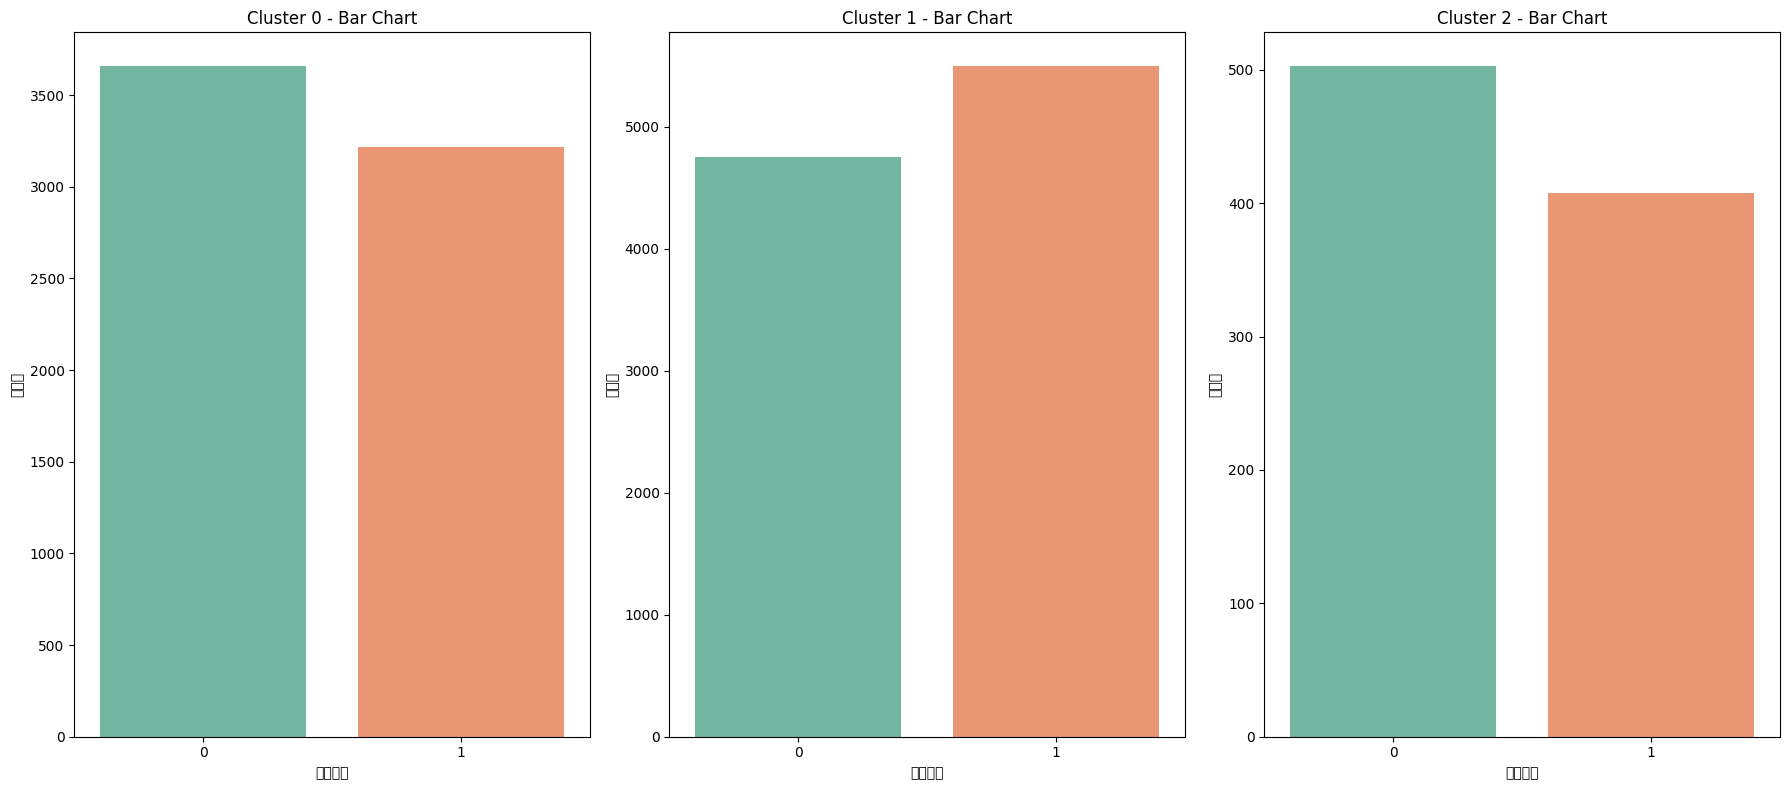

In [85]:
# 법인기업 빈도 차이 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for i, df in enumerate([df_군집0, df_군집1, df_군집2]):
    ax = sns.barplot(x=df['법인기업'].value_counts().index, y=df['법인기업'].value_counts(), palette='Set2', ax=axes[i])
    ax.set_title(f'Cluster {i} - Bar Chart')
    ax.set_xlabel('법인기업')
    ax.set_ylabel('빈도수')

plt.tight_layout()
plt.show()

<ipython-input-86-a54532af2ca8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['창업횟수'].value_counts().index, y=df['창업횟수'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-86-a54532af2ca8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['창업횟수'].value_counts().index, y=df['창업횟수'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-86-a54532af2ca8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['창업횟수'].value_counts().index, y=df['창업횟수'].value_counts(), palette='Set2', ax=axes[i])
<ipython-inpu

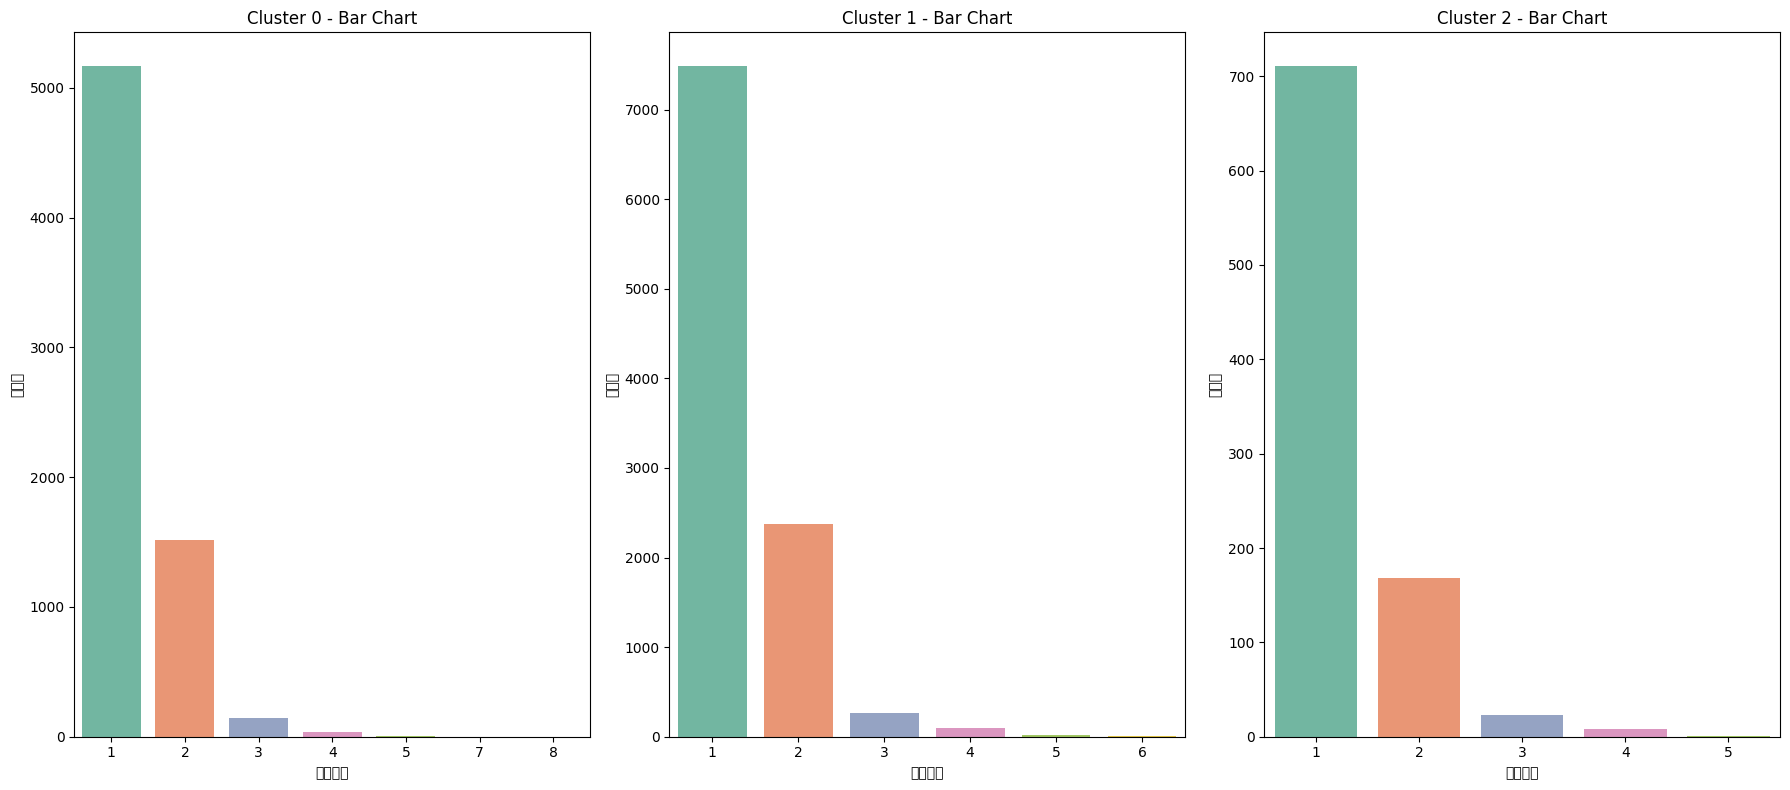

In [86]:
# 창업횟수 빈도 차이 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for i, df in enumerate([df_군집0, df_군집1, df_군집2]):
    ax = sns.barplot(x=df['창업횟수'].value_counts().index, y=df['창업횟수'].value_counts(), palette='Set2', ax=axes[i])
    ax.set_title(f'Cluster {i} - Bar Chart')
    ax.set_xlabel('창업횟수')
    ax.set_ylabel('빈도수')

plt.tight_layout()
plt.show()

<ipython-input-88-36b96592383d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['창업자학력'].value_counts().index, y=df['창업자학력'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-88-36b96592383d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['창업자학력'].value_counts().index, y=df['창업자학력'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-88-36b96592383d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['창업자학력'].value_counts().index, y=df['창업자학력'].value_counts(), palette='Set2', ax=axes[i])
<ipytho

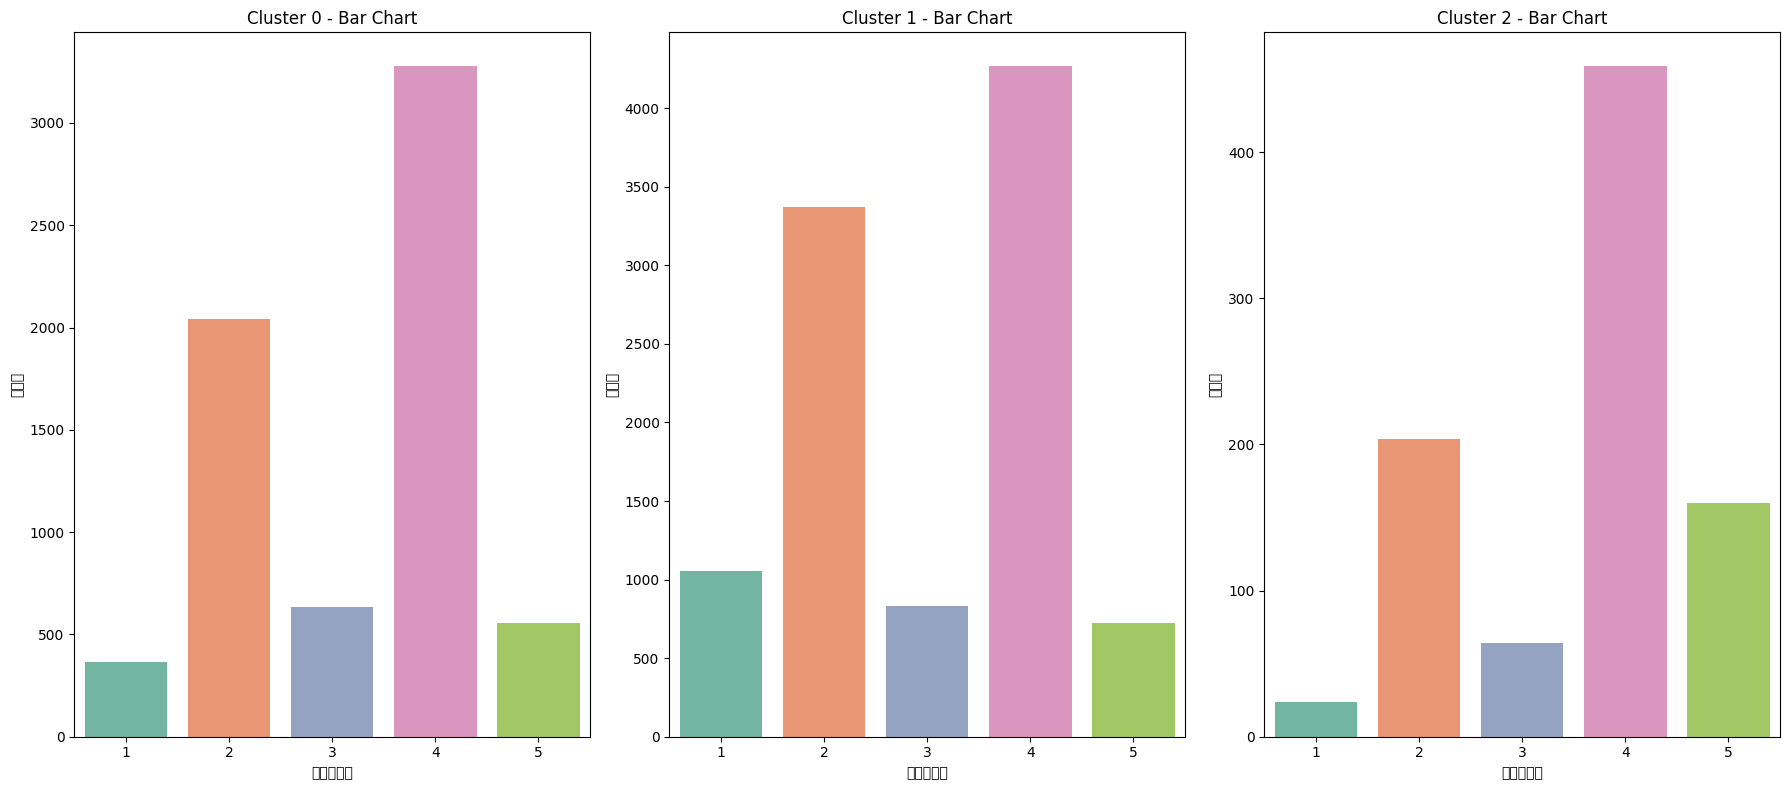

In [88]:
# 창업자학력 빈도 차이 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for i, df in enumerate([df_군집0, df_군집1, df_군집2]):
    ax = sns.barplot(x=df['창업자학력'].value_counts().index, y=df['창업자학력'].value_counts(), palette='Set2', ax=axes[i])
    ax.set_title(f'Cluster {i} - Bar Chart')
    ax.set_xlabel('창업자학력')
    ax.set_ylabel('빈도수')

plt.tight_layout()
plt.show()

<ipython-input-89-91ddd3db8cbf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['상업지역'].value_counts().index, y=df['상업지역'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-89-91ddd3db8cbf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['상업지역'].value_counts().index, y=df['상업지역'].value_counts(), palette='Set2', ax=axes[i])
<ipython-input-89-91ddd3db8cbf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['상업지역'].value_counts().index, y=df['상업지역'].value_counts(), palette='Set2', ax=axes[i])
<ipython-inpu

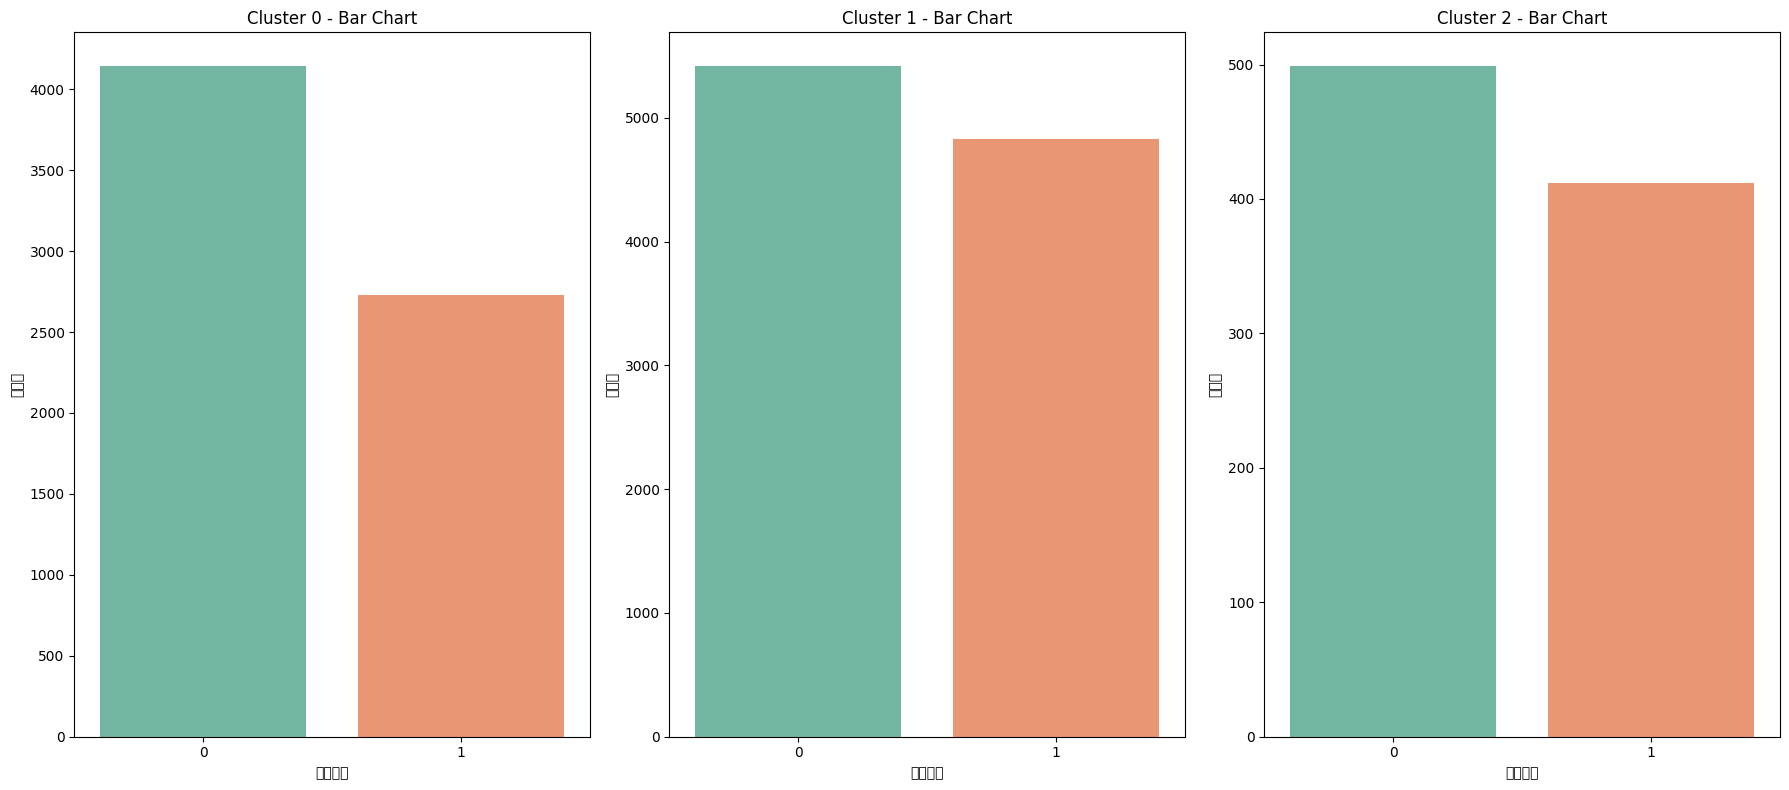

In [89]:
# 상업지역 빈도 차이 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for i, df in enumerate([df_군집0, df_군집1, df_군집2]):
    ax = sns.barplot(x=df['상업지역'].value_counts().index, y=df['상업지역'].value_counts(), palette='Set2', ax=axes[i])
    ax.set_title(f'Cluster {i} - Bar Chart')
    ax.set_xlabel('상업지역')
    ax.set_ylabel('빈도수')

plt.tight_layout()
plt.show()